In [2]:
import numpy as np
import pymc3 as pm
import theano
from codebase.file_utils import save_obj, load_obj, make_folder, path_backslash
from pdb import set_trace
from scipy.stats import multivariate_normal, norm
from scipy.optimize import minimize
from codebase.plot import *
from scipy import stats
import matplotlib.pyplot as plt
import theano.tensor as tt

alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [3]:
realmu = 2
np.random.seed(5)
y = norm.rvs(loc= realmu, size=100)
y

array([ 2.44122749,  1.66912985,  4.43077119,  1.74790787,  2.10960984,
        3.58248112,  1.0907676 ,  1.40836334,  2.18760323,  1.67013004,
        0.80723539,  1.79512349,  1.64117105,  2.6034716 ,  0.33521147,
        1.29982096,  3.15139101,  3.85733101,  0.48882044,  2.64484751,
        1.01939211,  1.14314685,  1.12812082,  1.57749207,  2.99643983,
        2.71242127,  2.05914424,  1.63668912,  2.00328884,  1.89406956,
        2.79305332,  1.36842837,  1.99380509,  1.89893239,  1.94769185,
        2.24921766,  2.19766009,  3.33484857,  1.91312439,  3.56153229,
        1.69414698,  1.52226858,  2.10073819,  2.35543847,  2.26961241,
        3.29196338,  3.13934298,  2.4944404 ,  1.66366374,  1.89938565,
        3.41339802,  2.22125412,  0.68922687,  1.31043477,  1.42248677,
        3.15220477,  1.89283602,  4.26010677,  2.65661947,  2.12480683,
        1.56429608,  2.97217931,  1.75928886,  1.17587655,  2.56813272,
        2.01275832,  3.18906073,  1.92640668, -0.85968797,  2.78

In [5]:
with pm.Model() as model:
    alpha = pm.Normal("alpha", 0, sigma=1e2)
    y_pm = pm.Data('y', y)
    obs = pm.Normal('obs', mu=alpha, sigma=1, observed=y_pm)

with model:
    advi = pm.fit(method="advi")

    

Average Loss = 143.79: 100%|██████████| 10000/10000 [00:01<00:00, 7128.16it/s]
Finished [100%]: Average Loss = 143.78


In [6]:
vb_mean = advi.mean.eval(); vb_mean

array([2.0937062])

In [7]:
vb_cov = advi.cov.eval(); vb_cov

/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


array([[0.05180612]])

In [6]:
# df = pm.summary(advi.sample(10000))
# df
# pd.DataFrame(advi.mean.eval(), index=df.index).to_dict()

In [6]:

def get_log_likelihood(z,y,alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    s1 = (y*np.log(pi_z))+((1.-y)*(np.log(1. - pi_z)))
    return np.sum(s1)

def logprior(z):
    return norm.logpdf(z)

def get_neg_posterior(z,y,alpha, beta):
    return -1.*(get_log_likelihood(z,y,alpha, beta)+norm.logpdf(z))

def get_grad_pi_z(z, alpha, beta):
    exp_eta = np.exp(alpha +  z @ beta.T)
    return (exp_eta *  beta.T)/(1+exp_eta)**2

def get_fisher_information(z, y, alpha, beta):
    pi_z = get_pi_z(z, alpha, beta)
    grad_pi_z = get_grad_pi_z(z, alpha, beta)
    r1 =grad_pi_z**2
    r2 =pi_z*(1.-pi_z)
    return 1. + np.sum(r1/r2)

lglk = get_log_likelihood(z, y, alpha, beta) 
lglk

-3.324738377296253

In [7]:
### analytical posterior pdf
x = np.linspace(-3,3,1000)
lposts = np.zeros(1000)
for i in range(1000):
    z = x[i].reshape((1,1))
    lposts[i] = get_log_likelihood(z, y, alpha, beta) + logprior(z)
posts = np.exp(lposts)
posts = posts/np.sum(posts*6/1000)

In [8]:
## simple Laplace approx

M = x[np.argmax(posts)].reshape((1,1)) # mean at the mode
h = 0.000001  # numerical second derivative
f1 = get_log_likelihood(M+h, y,alpha,beta) + logprior(M+h)
f2 = get_log_likelihood(M, y,alpha,beta) + logprior(M)
f3 = get_log_likelihood(M-h, y,alpha,beta) + logprior(M-h)
V=-(h*h)/(f1-2*f2+f3) # variance being 2nd derivative evaluated at the mode.

In [9]:
def get_laplace_approx(y, alpha, beta):
    res = minimize(get_neg_posterior, np.array([[1]]), args=(y, alpha, beta), method='BFGS')
    cov_matrix = get_fisher_information(res.x, y, alpha, beta)
    return multivariate_normal(mean = res.x, cov = cov_matrix**(-1))
lapldist =  get_laplace_approx(y, alpha, beta)
laplace_pdf = lapldist.pdf(x)

In [10]:
vb_pdf = multivariate_normal.pdf(x, mean= vb_mean, cov = vb_cov)

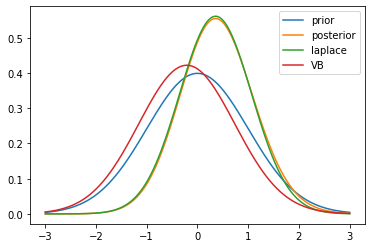

In [11]:
plt.plot(x,norm.pdf(x),label='prior')
# plt.plot(x,np.squeeze(norm.pdf(x,M,np.sqrt(V))),label='Kostas_laplace')
plt.plot(x,posts,label='posterior')
plt.plot(x,laplace_pdf,label='laplace')
plt.plot(x,vb_pdf,label='VB')
plt.legend()

In [13]:
# 2 D example for VB
np.random.seed(5)
theta=dict()
alpha = np.array([0, 0.1, -0.1,-0.2,0.2])
beta = np.array([[1,0.8,0.9,0.5,1.3],
                [1,0.8,0.9,0.5,1.3]]).T
z = np.array([[-2,-2]])
y = np.random.binomial(1, get_pi_z(z, alpha, beta))


In [14]:
with pm.Model() as model:
    alpha = pm.Data('alpha', alpha)
    beta = pm.Data('beta', beta)
    y = pm.Data('y', y)
    z = pm.Normal('z', 0, 1, shape=(2,))
#     obs = pm.Normal('obs', z, 1, observed=y)
    p = tt.nnet.softmax(alpha + z @ beta.T)
    obs = pm.Categorical('obs', p=p, observed=y)


/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
  import sys
/home/konstantinos/anaconda3/envs/smc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
